In [2]:
! pip install cma

In [3]:
import os

# Check if the notebook is running on Colab
if 'COLAB_GPU' in os.environ:
    # This block will run only in Google Colab
    IN_COLAB = True
    print("Running on Google Colab. Cloning the repository.")
    !git clone https://github.com/pedro15sousa/R244-wm-load-balancing.git
    %cd R244-wm-load-balancing/notebooks
else: 
    # This block will run if not in Google Colab
    IN_COLAB = False
    print("Not running on Google Colab. Assuming local environment.")

Not running on Google Colab. Assuming local environment.


In [4]:
import sys
sys.path.append('..')  # This adds the parent directory (main_folder) to the Python path

In [5]:
"""
Training a linear controller on latent + recurrent state
with CMAES.

This is a bit complex. num_workers slave threads are launched
to process a queue filled with parameters to be evaluated.
"""
import argparse
import sys
from os.path import join, exists
from os import mkdir, unlink, listdir, getpid
from time import sleep
from torch.multiprocessing import Process, Queue
import torch
import cma
from models import Controller
from tqdm import tqdm
import numpy as np
from utils.misc import RolloutGenerator, ASIZE, RSIZE, LSIZE
from utils.misc import load_parameters
from utils.misc import flatten_parameters
from utils.misc import slave_routine, set_slave_routines

In [6]:
# parsing
# parser = argparse.ArgumentParser()
# parser.add_argument('--logdir', type=str, help='Where everything is stored.')
# parser.add_argument('--n-samples', type=int, help='Number of samples used to obtain '
#                     'return estimate.')
# parser.add_argument('--pop-size', type=int, help='Population size.')
# parser.add_argument('--target-return', type=float, help='Stops once the return '
#                     'gets above target_return')
# parser.add_argument('--display', action='store_true', help="Use progress bars if "
#                     "specified.")
# parser.add_argument('--max-workers', type=int, help='Maximum number of workers.',
#                     default=32)
# args = parser.parse_args()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

args = {
    'n_samples': 4,   # input batch size for training (default: 32)
    'epochs': 60,     # number of epochs to train (default: 1000)
    'logdir': '../exp_dir',  # Directory where results are logged
    'pop_size': 4,
    'target_return': -2000000,
    "display": True,
    "max_workers": 2, 
}

In [7]:
# Max number of workers. M

# multiprocessing variables
n_samples = args['n_samples']
pop_size = args["pop_size"]
num_workers = min(args["max_workers"], n_samples * pop_size)
time_limit = 10000

# create tmp dir if non existent and clean it if existent
tmp_dir = join(args['logdir'], 'tmp')
if not exists(tmp_dir):
    mkdir(tmp_dir)
else:
    for fname in listdir(tmp_dir):
        unlink(join(tmp_dir, fname))

# create ctrl dir if non exitent
ctrl_dir = join(args['logdir'], 'ctrl')
if not exists(ctrl_dir):
    mkdir(ctrl_dir)

In [8]:
################################################################################
#                           Thread routines                                    #
################################################################################
def slave_routine(p_queue, r_queue, e_queue, p_index):
    """ Thread routine.

    Threads interact with p_queue, the parameters queue, r_queue, the result
    queue and e_queue the end queue. They pull parameters from p_queue, execute
    the corresponding rollout, then place the result in r_queue.

    Each parameter has its own unique id. Parameters are pulled as tuples
    (s_id, params) and results are pushed as (s_id, result).  The same
    parameter can appear multiple times in p_queue, displaying the same id
    each time.

    As soon as e_queue is non empty, the thread terminate.

    When multiple gpus are involved, the assigned gpu is determined by the
    process index p_index (gpu = p_index % n_gpus).

    :args p_queue: queue containing couples (s_id, parameters) to evaluate
    :args r_queue: where to place results (s_id, results)
    :args e_queue: as soon as not empty, terminate
    :args p_index: the process index
    """
    # init routine
    # gpu = p_index % torch.cuda.device_count()
    # device = torch.device('cuda:{}'.format(gpu) if torch.cuda.is_available() else 'cpu')

    # Check if CUDA-capable GPUs are available
    if torch.cuda.is_available() and torch.cuda.device_count() > 0:
        gpu = p_index % torch.cuda.device_count()
        device = torch.device('cuda:{}'.format(gpu))
    else:
        # Use CPU if no GPUs are available
        device = torch.device('cpu')

    # redirect streams
    sys.stdout = open(join(tmp_dir, str(getpid()) + '.out'), 'a')
    sys.stderr = open(join(tmp_dir, str(getpid()) + '.err'), 'a') 

    with torch.no_grad():
        r_gen = RolloutGenerator(args['logdir'], device, time_limit)
        print("Rollout generator process {} ready!".format(p_index))
        while e_queue.empty():
            if p_queue.empty():
                sleep(.1)
            else:
                s_id, params = p_queue.get()
                r_queue.put((s_id, r_gen.rollout(params)))

In [9]:
################################################################################
#                           Evaluation                                         #
################################################################################
def evaluate(solutions, results, rollouts=100):
    """ Give current controller evaluation.

    Evaluation is minus the cumulated reward averaged over rollout runs.

    :args solutions: CMA set of solutions
    :args results: corresponding results
    :args rollouts: number of rollouts

    :returns: minus averaged cumulated reward
    """
    index_min = np.argmin(results)
    best_guess = solutions[index_min]
    restimates = []

    for s_id in range(rollouts):
        p_queue.put((s_id, best_guess))

    print("Evaluating...")
    for _ in tqdm(range(rollouts)):
        while r_queue.empty():
            sleep(.1)
        restimates.append(r_queue.get()[1])

    print("Evaluation finished: ", np.mean(restimates))
    return best_guess, np.mean(restimates), np.std(restimates)

In [9]:
################################################################################
#                           Launch CMA                                         #
################################################################################
if __name__ == '__main__':
    # define queues and set workers
    p_queue, r_queue, e_queue = set_slave_routines(num_workers, tmp_dir, args, time_limit)
    
    controller = Controller(LSIZE, RSIZE, ASIZE)  # dummy instance

    # define current best and load parameters
    cur_best = None
    ctrl_file = join(ctrl_dir, 'best.tar')
    print("Attempting to load previous best...")
    if exists(ctrl_file):
        state = torch.load(ctrl_file, map_location={'cuda:0': 'cpu'})
        cur_best = - state['reward']
        controller.load_state_dict(state['state_dict'])
        print("Previous best was {}...".format(-cur_best))

    parameters = controller.parameters()
    es = cma.CMAEvolutionStrategy(flatten_parameters(parameters), 0.1,
                                {'popsize': pop_size})

    epoch = 0
    log_step = 3

    # p_queue, r_queue, e_queue = set_queues(num_workers)

    while not es.stop():
        print("\n********** Generation {} ************".format(epoch))
        if cur_best is not None and - cur_best > args['target_return']:
            print("Already better than target, breaking...")
            break

        r_list = [0] * pop_size  # result list
        solutions = es.ask()

        # push parameters to queue
        for s_id, s in enumerate(solutions):
            for _ in range(n_samples):
                p_queue.put((s_id, s))

        # retrieve results
        if args['display']:
            pbar = tqdm(total=pop_size * n_samples)
        for _ in range(pop_size * n_samples):
            while r_queue.empty():
                sleep(.1)
            r_s_id, r = r_queue.get()
            r_list[r_s_id] += r / n_samples
            if args['display']:
                pbar.update(1)
        if args['display']:
            pbar.close()

        es.tell(solutions, r_list)
        es.disp()

        # evaluation and saving
        if epoch % log_step == log_step - 1:
            best_params, best, std_best = evaluate(solutions, r_list)
            print("Current evaluation: {}".format(-best))
            if cur_best != None: print("Current overall best: {}".format(-cur_best))
            if not cur_best or best < cur_best:
                cur_best = best
                print("Saving new best with value {}+-{}...".format(-cur_best, std_best))
                load_parameters(best_params, controller)
                torch.save(
                    {'epoch': epoch,
                    'reward': - cur_best,
                    'state_dict': controller.state_dict()},
                    join(ctrl_dir, 'best.tar'))
            if - best > args['target_return']:
                print("Terminating controller training with value {}...".format(-best))
                break


        epoch += 1

    es.result_pretty()
    e_queue.put('EOP')


Attempting to load previous best...
Previous best was -8107804.96...
(2_w,4mirr1)-aCMA-ES (mu_w=1.5,w_1=80%) in dimension 760 (seed=1074881, Thu Jan 11 10:51:33 2024)

********** Generation 0 ************


  0%|          | 0/16 [00:00<?, ?it/s]

INFO:root:Making new env load_balance
INFO:root:Making new env load_balance
100%|██████████| 16/16 [00:04<00:00,  3.54it/s]

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      4 7.986229000000000e+06 1.0e+00 9.94e-02  1e-01  1e-01 0:04.5



********** Generation 1 ************


100%|██████████| 16/16 [00:02<00:00,  7.75it/s]

    2      8 9.486152000000000e+06 1.0e+00 9.88e-02  1e-01  1e-01 0:06.6



********** Generation 2 ************


100%|██████████| 16/16 [00:02<00:00,  7.73it/s]

    3     12 9.722082500000000e+06 1.0e+00 9.82e-02  1e-01  1e-01 0:08.7


Evaluating...


100%|██████████| 100/100 [00:12<00:00,  7.94it/s]


Evaluation finished:  15323914.36
Current evaluation: -15323914.36
Current overall best: -8107804.96

********** Generation 3 ************


100%|██████████| 16/16 [00:02<00:00,  7.39it/s]



********** Generation 4 ************


100%|██████████| 16/16 [00:02<00:00,  7.36it/s]

    5     20 9.075379500000000e+06 1.0e+00 9.72e-02  1e-01  1e-01 0:13.1



********** Generation 5 ************


100%|██████████| 16/16 [00:02<00:00,  7.04it/s]


Evaluating...


100%|██████████| 100/100 [00:13<00:00,  7.61it/s]


Evaluation finished:  12234831.92
Current evaluation: -12234831.92
Current overall best: -8107804.96

********** Generation 6 ************


100%|██████████| 16/16 [00:02<00:00,  7.02it/s]

    7     28 5.117705500000000e+06 1.0e+00 9.62e-02  1e-01  1e-01 0:17.6



********** Generation 7 ************


  0%|          | 0/16 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [10]:
controller = Controller(LSIZE, RSIZE, ASIZE) 
ctrl_file = join(ctrl_dir, 'best.tar')
state = torch.load(ctrl_file, map_location={'cuda:0': 'cpu'})
training_rewards = state['training_rewards']
training_variances = state['training_variances']
action_history = state['action_history']
variance_history = state['variance_history']
reward_history = state['reward_history'] 

In [12]:
print(len(action_history), max(variance_history), max(reward_history))

10352 7.380334760524186e+16 -3167698.0625


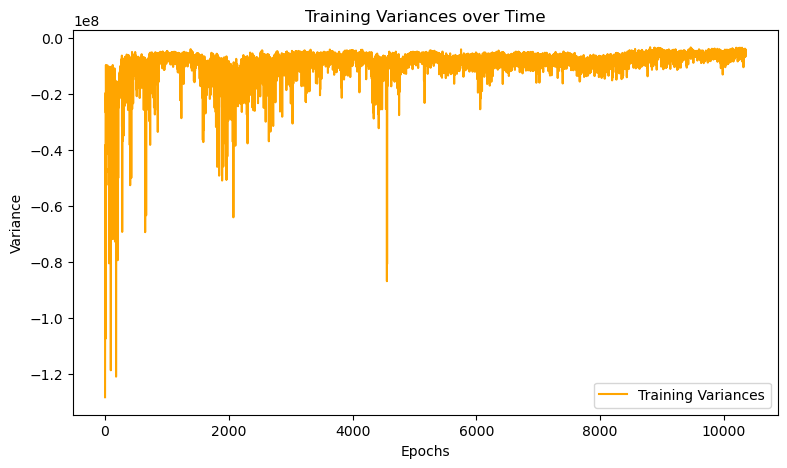

In [72]:
plt.figure(figsize=(20, 5))

# Plotting training variances
plt.subplot(1, 2, 2)
plt.plot(reward_history, label='Training Variances', color='orange')
plt.title('Training Variances over Time')
plt.xlabel('Epochs')
plt.ylabel('Variance')
plt.legend()

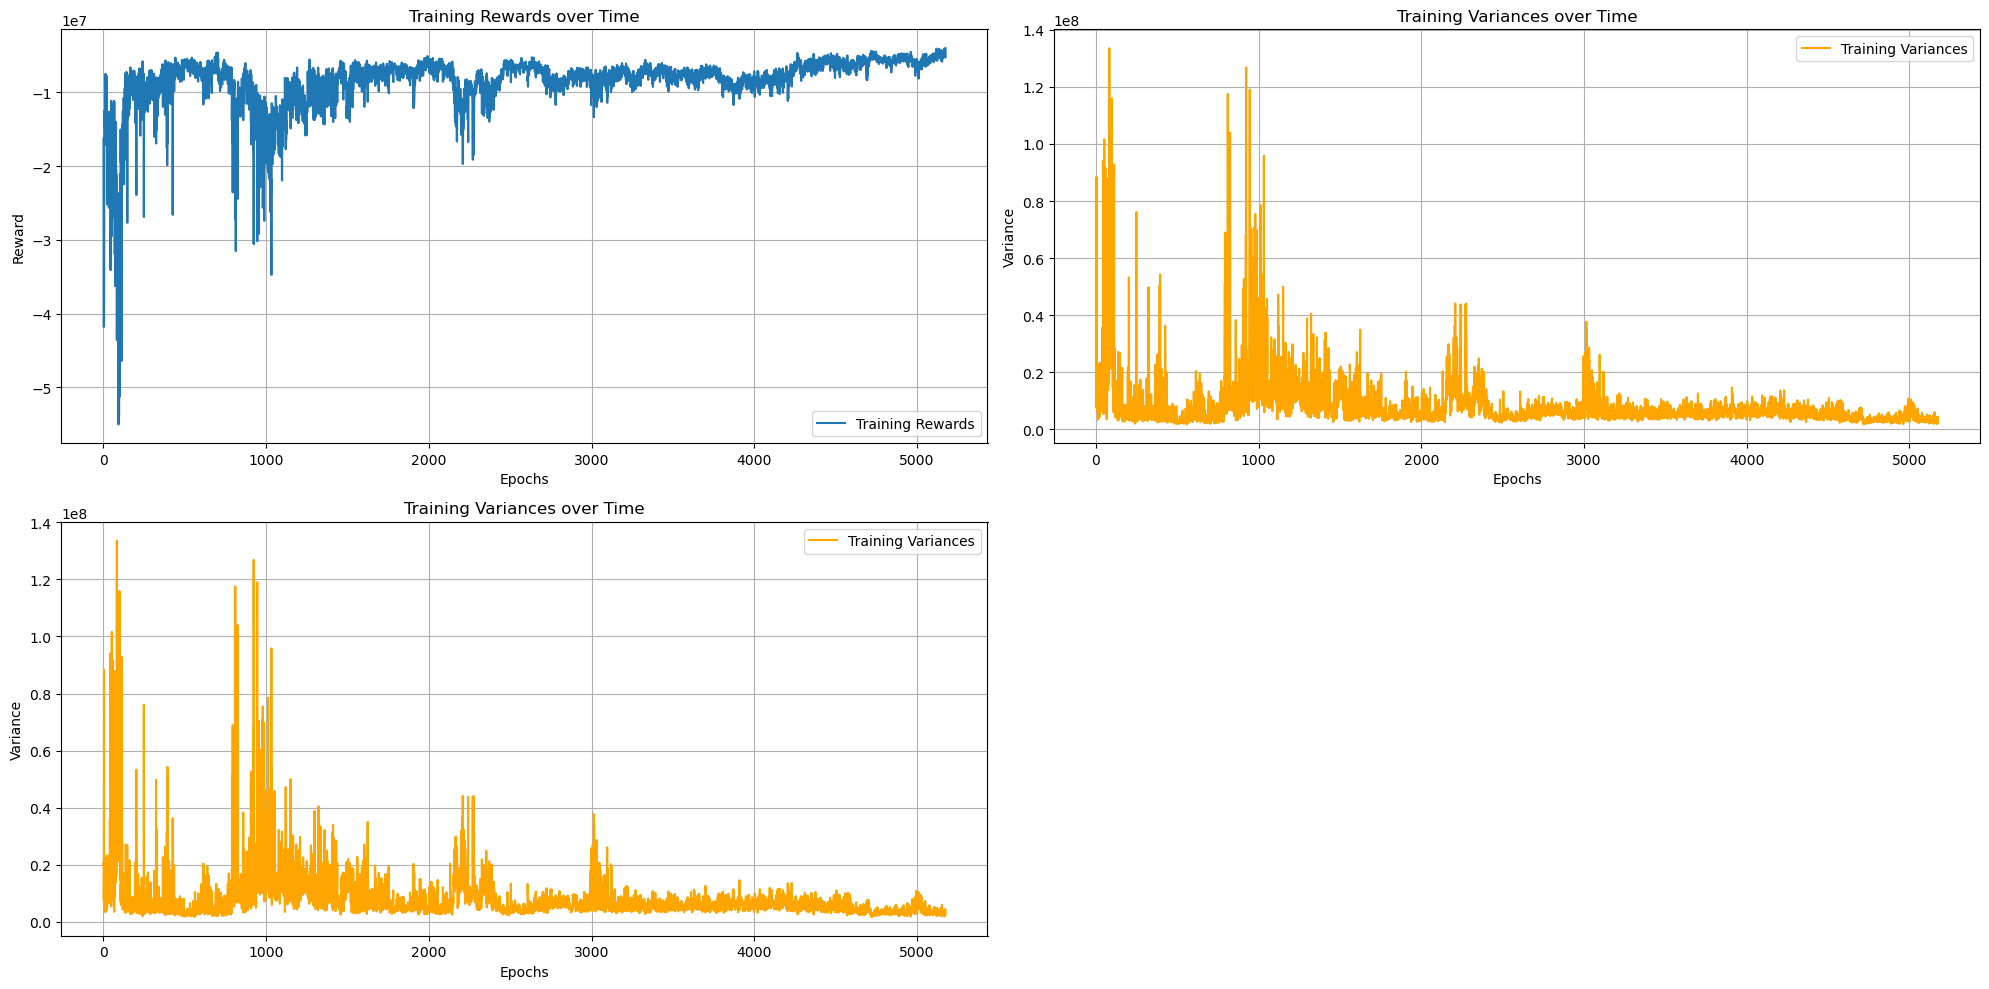

In [78]:
plt.figure(figsize=(20, 10))

# Plotting training rewards
# Plotting training rewards
plt.subplot(2, 2, 1)
plt.plot(training_rewards, label='Training Rewards')
plt.fill_between(range(len(training_rewards)), 
                 np.array(training_rewards) - training_std_dev, 
                 np.array(training_rewards) + training_std_dev, 
                 color='blue', alpha=0.2)
plt.title('Training Rewards over Time')
plt.xlabel('Epochs')
plt.ylabel('Reward')
plt.legend()
plt.grid(True)

# Plotting training variances
plt.subplot(2, 2, 2)
plt.plot(training_variances, label='Training Variances', color='orange')
plt.title('Training Variances over Time')
plt.xlabel('Epochs')
plt.ylabel('Variance')
plt.legend()
plt.grid(True)

# Plotting training variances
plt.subplot(2, 2, 3)
plt.plot(training_variances, label='Training Variances', color='orange')
plt.title('Training Variances over Time')
plt.xlabel('Epochs')
plt.ylabel('Variance')
plt.legend()
plt.grid(True)

plt.tight_layout()

In [52]:
print(len(training_variances))
print(max(training_variances))

print(max(training_rewards))

5176
133552065.24855302
-4023682.69


In [54]:
print(training_rewards)

[-16309015.19 -40245983.86 -41800267.85 ...  -4411122.94  -5280680.21
  -4023682.69]


In [55]:
print(training_variances)

[ 7864151.15073416 20749852.51998664 19457173.54344875 ...
  2666703.15150067  4507983.87788312  2377545.01933303]


[4113.54213444 4146.33628036 4336.92396645 ... 1816.39904562 1817.54562858
 1804.80051098]
[-17986574.988  -17981383.9954 -17766447.4174 ...  -4924242.198
  -4925056.5772  -4893637.8754]
[-17978512.44541649 -17973257.17629049 -17757947.04642576 ...
  -4920682.05587058  -4921494.18776798  -4890100.46639848]
[-17994637.53058351 -17989510.8145095  -17774947.78837424 ...
  -4927802.34012942  -4928618.96663203  -4897175.28440152]


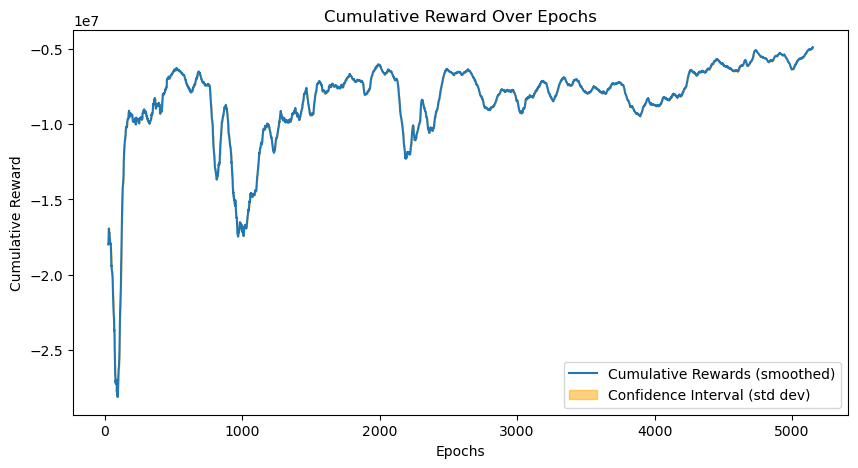

In [83]:
import matplotlib.pyplot as plt

training_rewards = np.array(training_rewards)
training_variances = np.array(training_variances)

# Now you can calculate the moving average if desired
def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Apply moving average to rewards and variances
window_size = 50  # or any value that suits your data
smoothed_rewards = moving_average(training_rewards, window_size)
smoothed_variances = moving_average(training_variances, window_size)

# Calculate the standard deviation (which is the square root of variance)
smoothed_std = np.sqrt(smoothed_variances)
print(smoothed_std)
print(smoothed_rewards)

# Calculate the upper and lower bounds for the confidence interval
upper_bound = smoothed_rewards + 1.96 * smoothed_std
lower_bound = smoothed_rewards - 1.96 * smoothed_std
print(upper_bound)
print(lower_bound)

# To account for the offset introduced by the moving average, we'll start the x-axis from half the window size
x_values = np.arange(window_size//2, window_size//2 + len(smoothed_rewards))

# Create the plot with error bars
plt.figure(figsize=(10, 5))
plt.plot(x_values, smoothed_rewards, label='Cumulative Rewards (smoothed)')
plt.fill_between(x_values, lower_bound, upper_bound, color='orange', alpha=0.5, label='Confidence Interval (std dev)')
plt.title('Cumulative Reward Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Cumulative Reward')
plt.legend()
plt.show()

# # Create the plot
# plt.figure(figsize=(10, 5))
# plt.plot(training_rewards, label='Training Loss')
# plt.title('Training Loss Over Epochs')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

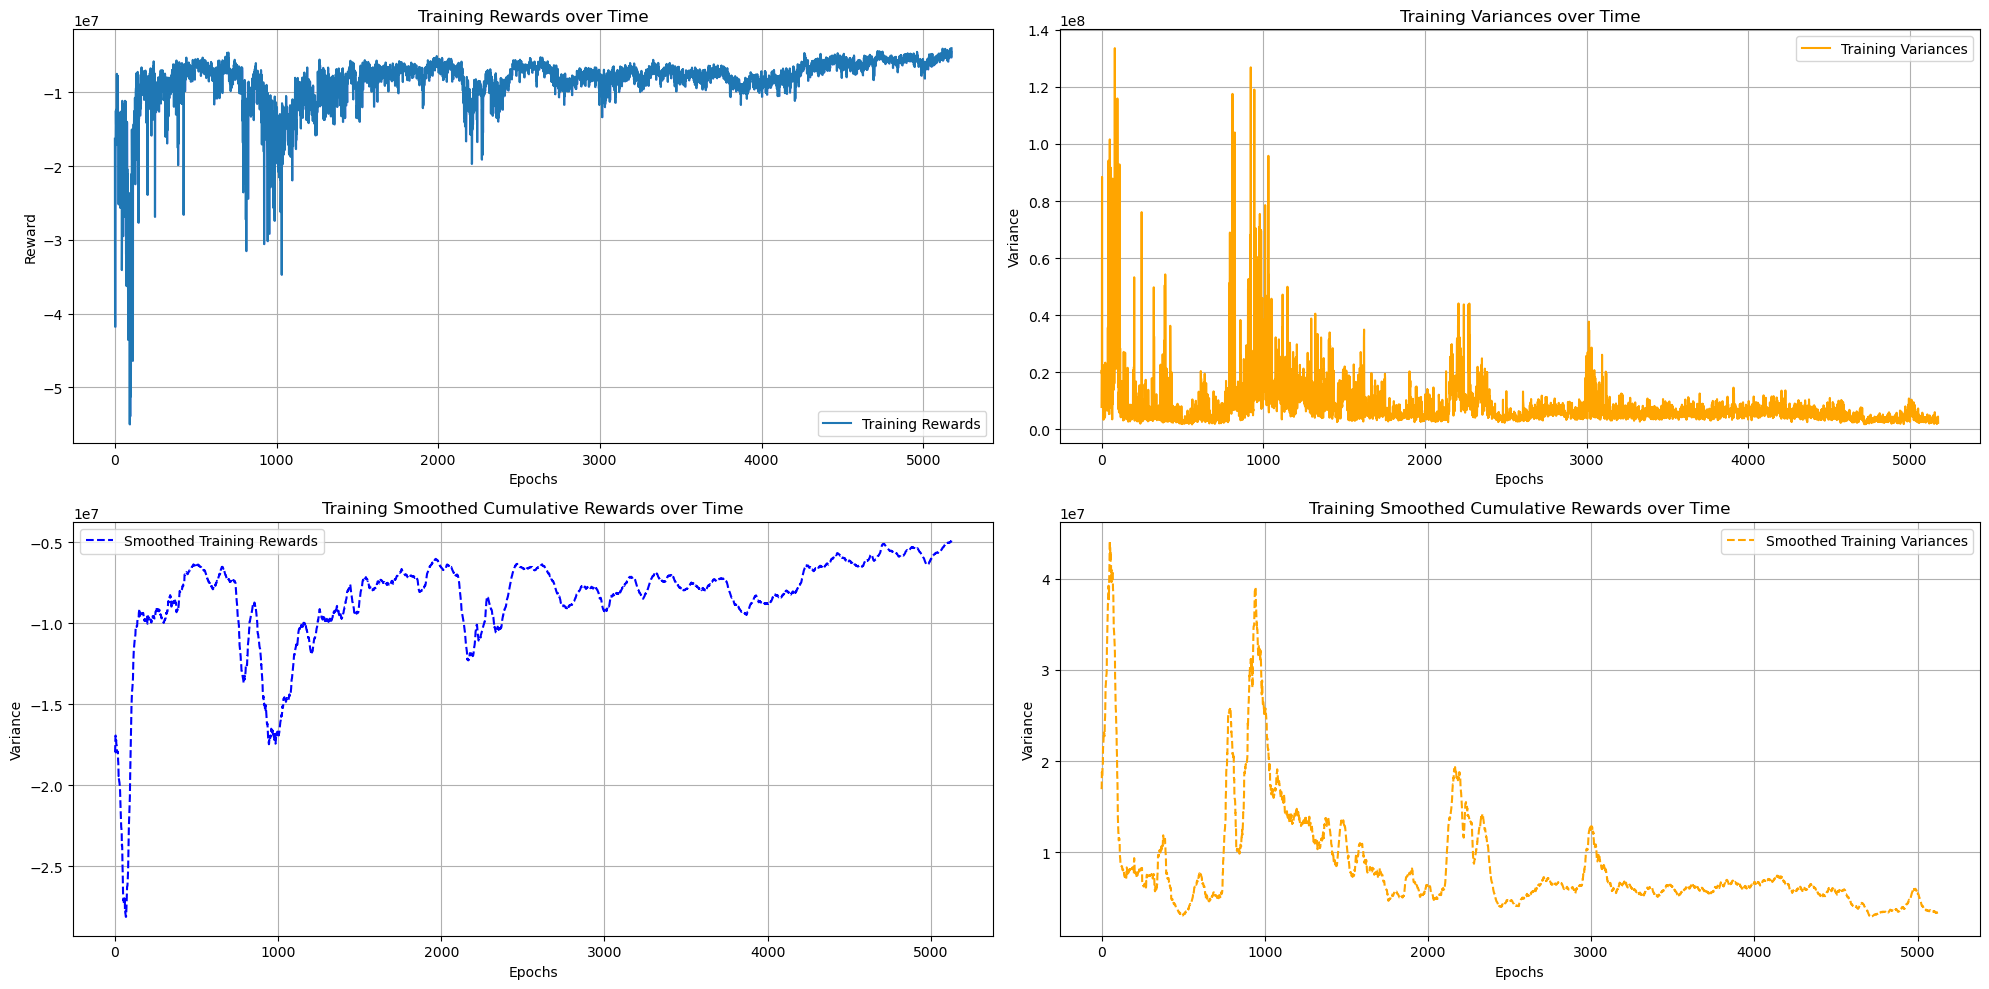

In [84]:
plt.figure(figsize=(20, 10))

# Plotting training rewards
# Plotting training rewards
plt.subplot(2, 2, 1)
plt.plot(training_rewards, label='Training Rewards')
plt.fill_between(range(len(training_rewards)), 
                 np.array(training_rewards) - training_std_dev, 
                 np.array(training_rewards) + training_std_dev, 
                 color='blue', alpha=0.2)
plt.title('Training Rewards over Time')
plt.xlabel('Epochs')
plt.ylabel('Reward')
plt.legend()
plt.grid(True)

# Plotting training variances
plt.subplot(2, 2, 2)
plt.plot(training_variances, label='Training Variances', color='orange')
plt.title('Training Variances over Time')
plt.xlabel('Epochs')
plt.ylabel('Variance')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(smoothed_rewards, label='Smoothed Training Rewards', color='blue', linestyle='dashed')
plt.title('Training Smoothed Cumulative Rewards over Time')
plt.xlabel('Epochs')
plt.ylabel('Variance')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(smoothed_variances, label='Smoothed Training Variances', color='orange', linestyle='dashed')
plt.title('Training Smoothed Cumulative Rewards over Time')
plt.xlabel('Epochs')
plt.ylabel('Variance')
plt.legend()
plt.grid(True)

plt.tight_layout()